In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import os
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
import glob
from ultralytics import YOLO
import random

### Data 

In [2]:
data_dir = "UTKFace"

In [3]:
data = pd.DataFrame(columns=["image", "age"])

### Create dataframe from images

In [4]:
filenames = []
ages = []
for filename in glob.glob(f"{data_dir}/*.jpg"):
    age = int(filename.split("\\")[1].split("_")[0])
    filenames.append(filename)
    ages.append(age)

data_dict = {}
data_dict['image']=filenames
data_dict['age'] = ages   

data = pd.DataFrame.from_dict(data_dict)

In [5]:
data

,image,age
0,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100
1,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100
2,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100
3,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100
4,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100
...,...,...
23703,UTKFace\9_1_3_20161220222856346.jpg.chip.jpg,9
23704,UTKFace\9_1_3_20170104222949455.jpg.chip.jpg,9
23705,UTKFace\9_1_4_20170103200637399.jpg.chip.jpg,9
23706,UTKFace\9_1_4_20170103200814791.jpg.chip.jpg,9


<Axes: >

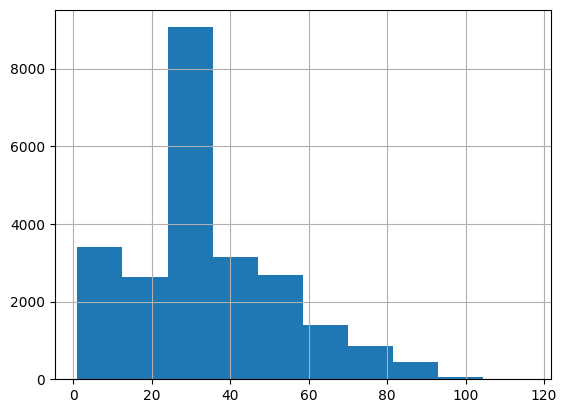

In [6]:
data['age'].hist()

### Devide age into chunks

In [5]:
def age_splitter(age):
    if 0 <= age <= 2:
       return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [6]:
data['target']=data['age'].map(age_splitter)

In [19]:
data

,image,age,target
0,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100,6
1,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100,6
2,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100,6
3,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100,6
4,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100,6
...,...,...,...
23703,UTKFace\9_1_3_20161220222856346.jpg.chip.jpg,9,1
23704,UTKFace\9_1_3_20170104222949455.jpg.chip.jpg,9,1
23705,UTKFace\9_1_4_20170103200637399.jpg.chip.jpg,9,1
23706,UTKFace\9_1_4_20170103200814791.jpg.chip.jpg,9,1


In [45]:
data['image']

0        UTKFace\100_0_0_20170112213500903.jpg.chip.jpg
1        UTKFace\100_0_0_20170112215240346.jpg.chip.jpg
2        UTKFace\100_1_0_20170110183726390.jpg.chip.jpg
3        UTKFace\100_1_0_20170112213001988.jpg.chip.jpg
4        UTKFace\100_1_0_20170112213303693.jpg.chip.jpg
                              ...                      
23703      UTKFace\9_1_3_20161220222856346.jpg.chip.jpg
23704      UTKFace\9_1_3_20170104222949455.jpg.chip.jpg
23705      UTKFace\9_1_4_20170103200637399.jpg.chip.jpg
23706      UTKFace\9_1_4_20170103200814791.jpg.chip.jpg
23707      UTKFace\9_1_4_20170103213057382.jpg.chip.jpg
Name: image, Length: 23708, dtype: object

### Randomly choose smaller subset for faster training

In [12]:
idxes = random.sample(list(np.arange(0, 23707)), 8000)
print(idxes)
data_small = data.iloc[idxes]

[19916, 20967, 7093, 76, 21619, 23414, 4624, 20706, 4264, 17138, 21491, 3992, 3199, 17615, 22891, 1810, 996, 14530, 2807, 2922, 12115, 23427, 8491, 7328, 9433, 22059, 4156, 4193, 10084, 18260, 20869, 23688, 2025, 14404, 12450, 17999, 13534, 17309, 12182, 14193, 5435, 1925, 3974, 1822, 9066, 5452, 20095, 21761, 20771, 14950, 9344, 1330, 4027, 2539, 8755, 925, 9481, 5755, 6906, 10829, 18762, 14960, 7728, 12738, 3152, 2312, 6392, 6629, 22243, 10324, 19394, 9129, 18601, 7072, 9703, 10019, 1723, 5857, 12743, 23418, 18149, 16324, 20898, 1462, 22608, 2538, 3520, 6174, 4112, 10134, 9305, 3469, 270, 19492, 15948, 22079, 5461, 15408, 7336, 19577, 16709, 19037, 21461, 12136, 4238, 20596, 15624, 11264, 13813, 15507, 16036, 9308, 9331, 4072, 9788, 6544, 7625, 463, 8087, 21982, 11627, 21239, 16336, 21376, 3386, 22293, 3623, 2940, 4067, 22365, 18171, 4755, 7669, 10268, 12643, 11510, 11362, 20397, 22290, 6177, 16879, 13944, 18773, 23110, 19969, 220, 8348, 6002, 13058, 22030, 5914, 22781, 2239, 21973, 

<Axes: >

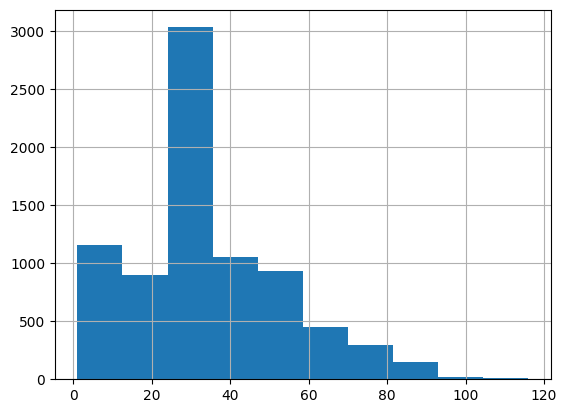

In [31]:
data_small.age.hist()

### Create dataset and dataloader

In [32]:
class AgeDataset(Dataset):
    """
    AgeDataset
    """
    def __init__(self, df, transform=None):
        self.images = df['image']
        self.age = df['age']    
        self.transform = transform         
           
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
                
        img_name = self.images.iloc[idx]
        
        img = Image.open(img_name).convert("RGB")
        
        target = self.age.iloc[idx]
        target = torch.tensor(target, dtype=torch.float32)
        
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)  
        
        return img, target

In [8]:
#define transform to be applied
transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(40)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [9]:
train_data, val_data = train_test_split(data_small, test_size=0.2, shuffle=True, random_state=42)

In [35]:
train_data['image'].iloc[0]

'UTKFace\\41_0_3_20170119171541497.jpg.chip.jpg'

<Axes: >

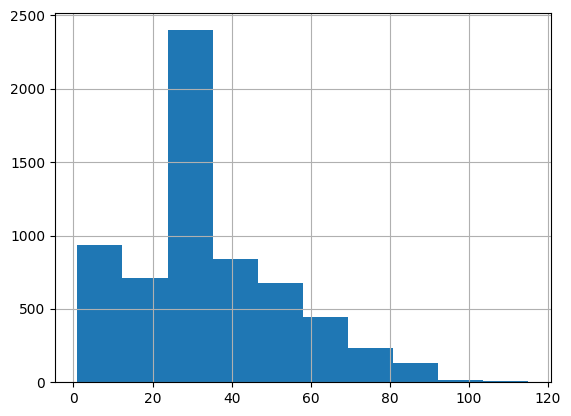

In [36]:
train_data.age.hist()

<Axes: >

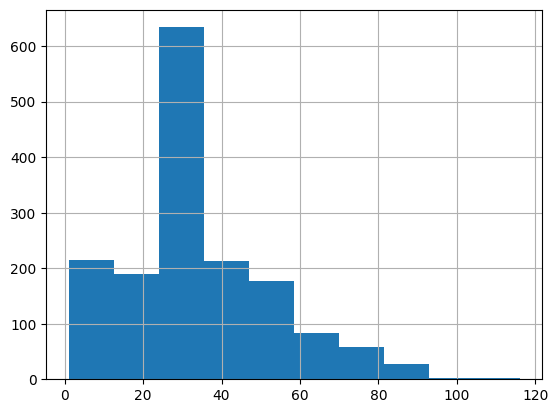

In [37]:
val_data.age.hist()

In [38]:
train_dataset = AgeDataset(train_data, transform=transforms)
val_dataset = AgeDataset(val_data, transform=transforms)

In [39]:
len(train_data)

6400

In [40]:
len(val_data)

1600

In [18]:
BATCH_SIZE = 64

In [41]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [49]:
images, target = next(iter(train_loader))

In [50]:
images

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [14]:
target

tensor([ 45.,  35.,  23.,  25.,  65.,  19.,  15.,  24.,  51.,   2.,  25.,  26.,
          1.,  38.,  40.,  34.,  55.,  31.,   2.,   3.,  34.,  40.,  17.,  32.,
         21.,  32.,  26.,  16.,   1.,  26.,  17.,  28.,  26.,  36.,  52.,  59.,
         81.,   1.,  23.,  45.,  25.,  47.,  23.,  72.,  30.,  70.,  65.,  32.,
          1.,   3., 116.,  78.,  37.,  32.,  17.,  45.,  28.,  81.,  27.,  35.,
         56.,  22.,  24.,  32.])

### Age model

In [43]:
class AgeModel(nn.Module):
    def __init__(self):
      super(AgeModel, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3)) #222
      self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)) #109
      self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3)) #52
      self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3)) #24
      self.avgpool2d = nn.AvgPool2d(kernel_size=(2,2))
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(p=0.5)
      self.linear1 = nn.Linear(in_features=9216, out_features=128)
      self.linear2 = nn.Linear(in_features=128, out_features=1) 

    def forward(self, input):

      x = self.avgpool2d(self.relu(self.conv1(input)))
      x = self.avgpool2d(self.relu(self.conv2(x)))
      x = self.avgpool2d(self.relu(self.conv3(x)))
      x = self.avgpool2d(self.relu(self.conv4(x)))
      x = nn.Flatten()(x)
      x = self.relu(self.linear1(x))
      x = self.dropout(x)
      x = self.linear2(x)
      
      return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
age_model = AgeModel()

In [24]:
def train(train_loader, val_loader, model, optimizer, loss_fn, epochs, save_path):
    
    min_loss = 100
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()

        model.to(device)
        
        epoch_losses = []
        
               
        for images, targets in train_loader:   

            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            
            outputs = outputs.squeeze()          
            
            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            
            
        print(f"Epoch {epoch:d}: Train Loss : {torch.tensor(epoch_losses).mean():.3f}")
                
        train_losses.append(torch.tensor(epoch_losses).mean())       
        
        
        #evaluation mode
        with torch.no_grad():
        
            model.eval()
            
            epoch_losses = []
            
            
            for images, targets in val_loader: 

                images = images.to(device)
                targets = targets.to(device)  
                
                outputs = model(images)
                outputs = outputs.squeeze()
                loss = loss_fn(outputs, targets)
                
                        
                epoch_losses.append(loss.item())
                
                                
        print(f"Epoch {epoch:d}: Val Loss : {torch.tensor(epoch_losses).mean():.3f}")
                
         
        val_losses.append(torch.tensor(epoch_losses).mean()) 
        
        mean_val_loss = torch.tensor(epoch_losses).mean()
        
        if mean_val_loss < min_loss:
            min_loss = mean_val_loss
            torch.save(model.state_dict(), save_path)
            print("Model saved")
        
    return train_losses, val_losses

In [25]:
EPOCHS = 100
learning_rate = 1.e-4

In [35]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(age_model.parameters(), lr=learning_rate)

In [36]:
train_losses, val_losses = train(train_loader, val_loader,
                                age_model, optimizer, loss_fn,
                                epochs=EPOCHS, save_path="models/age_model.pt")

torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64

AttributeError: 'list' object has no attribute 'mean'

### Face detection models
#### Haarcascade detection

In [18]:
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

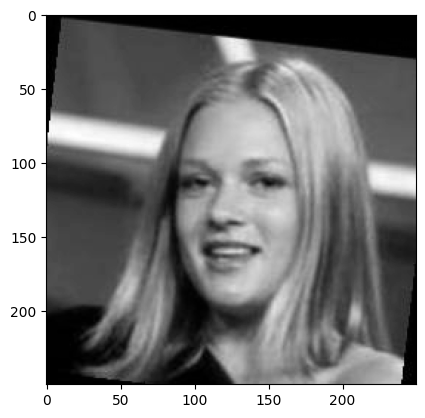

In [38]:
img = cv2.imread("lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")

In [29]:
faces = face_classifier.detectMultiScale(
    gray, scaleFactor=1.1, minNeighbors=5, minSize=(20, 20)
)

In [32]:
faces

array([[ 68,  69, 116, 116]])

In [31]:
for face in faces:
    cv2.rectangle(img, face[:2], face[2:], color=(0, 0, 255), thickness=1)

cv2.imshow("result", img)
cv2.waitKey(0)    
cv2.destroyAllWindows()

#### Face detection

In [2]:
import face_detection

In [25]:
detector = face_detection.build_detector(
  "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

c:\Projects\AgePrediction\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\AgePrediction\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [26]:
detections = detector.detect(img)

In [27]:
detections

array([[     87.492,      58.165,      173.98,      194.19,     0.99985]], dtype=float32)

In [32]:
def show_face(img, detections):
    img_copy = img.copy()
    
    for face in detections:
        face = list(map(int, face))
        
        cv2.rectangle(img_copy, face[:2], face[2:4], color=(0, 0, 255), thickness=1)

    cv2.imshow("result", img_copy)
    cv2.waitKey(0)    
    cv2.destroyAllWindows()

In [33]:
show_face(img, detections)

#### Yolov8 face

In [19]:
face_model=YOLO("face_models/yolov8n-face.pt")

In [6]:
detections = face_model(img)


0: 640x640 1 face, 124.1ms
Speed: 5.0ms preprocess, 124.1ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


In [23]:
detections[0].boxes.xyxy

tensor([[ 88.1385,  61.1320, 172.0035, 193.6369]])

In [35]:
show_face(img, detections[0].boxes.xyxy)

### Test on videos

In [122]:
age_model = AgeModel()
age_model.load_state_dict(torch.load("age_models/age_model.pt", map_location=torch.device('cpu')))
age_model.eval()

AgeModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (avgpool2d): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=9216, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

In [7]:
def preprocess_image(img):
    transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])
    transformed_img = transforms(img)
    return transformed_img.unsqueeze_(dim=0)

In [57]:
images, target = next(iter(train_loader))

In [61]:
age_model(images[0].unsqueeze_(dim=0))

tensor([[23.0882]], grad_fn=<AddmmBackward0>)

In [22]:
img = cv2.imread("lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg")
transformed_img = preprocess_image(img)
age_model(transformed_img)

tensor([[22.2641]], grad_fn=<AddmmBackward0>)

In [8]:
def draw_predictions(frame, predictions):
    for prediction in predictions:
        prediction = list(map(int, prediction))
        cv2.rectangle(frame, prediction[:2], prediction[2:], color=(0, 255, 0), thickness=2)
        

In [9]:
def draw_age(frame, x, y, age):
    if "-" in str(age): #if it is range, for example "0-2"
        cv2.putText(frame, age, (x+10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale = 0.5, color=(0, 0, 255), thickness=2) 
    else:   #if it is age (one number) 
        cv2.putText(frame, str(int(age)), (x+10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale = 0.5, color=(0, 0, 255), thickness=2) 

In [133]:
video_file_name = "videos/video3.mp4"

In [127]:
if not os.path.exists("results"):
    os.mkdir("results")

In [137]:
cap = cv2.VideoCapture(video_file_name)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

name = video_file_name.split("/")[1].split(".")[0]

cap_writer = cv2.VideoWriter(f'results/{name}.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                        25, (frame_width, frame_height))


success, frame = cap.read()


while success:

    results = face_model(frame)
    draw_predictions(frame, results[0].boxes.xyxy)
    for face in results[0].boxes.xyxy:
        x1, y1, x2, y2 = list(map(int, face))
        ROI = frame[y1:y2, x1:x2]
        preprocessed_ROI = preprocess_image(ROI)
        age = age_model(preprocessed_ROI)[0].item()
        draw_age(frame, x1, y1, age)
        
    cap_writer.write(frame)
        
    cv2.imshow("img", frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break
        
    success, frame = cap.read()
 
cap.release()   
cv2.destroyAllWindows()

0: 384x640 1 face, 144.1ms
Speed: 2.2ms preprocess, 144.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 86.8ms
Speed: 1.2ms preprocess, 86.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 81.3ms
Speed: 2.0ms preprocess, 81.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 63.2ms
Speed: 1.0ms preprocess, 63.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 71.1ms
Speed: 1.0ms preprocess, 71.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 71.9ms
Speed: 2.0ms preprocess, 71.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 68.2ms
Speed: 1.0ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 73.4ms
Speed: 1.1ms preprocess, 73.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384

ValueError: tile cannot extend outside image

: 

### Age prediction model with classification into age categories

#### We have 7 classes: 
* 0-2
* 3-9
* 10-20
* 21-27
* 28-45
* 46-65
* 66-116

In [10]:
classes = ['0-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

In [13]:
counts = data_small['target'].value_counts()

In [14]:
counts

target
4    2539
3    1866
5    1353
2     606
6     595
0     531
1     510
Name: count, dtype: int64

In [15]:
weights = data_small.shape[0]/counts

In [16]:
#compute weights because of class imbalance problem
weights = torch.tensor(weights, dtype=torch.float32)
weights

tensor([ 3.1508,  4.2872,  5.9128, 13.2013, 13.4454, 15.0659, 15.6863])

### Age Range Dataset

In [15]:
class AgeRangeDataset(Dataset):
    """
    Age Range Dataset
    """
    def __init__(self, df, transform=None):
        self.images = df['image']
        self.targets = df['target']    
        self.transform = transform         
           
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
                
        img_name = self.images.iloc[idx]
        
        img = Image.open(img_name).convert("RGB")
        
        target = self.targets.iloc[idx]
        target = torch.tensor(target, dtype=torch.long)
        
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)  
        
        return img, target

In [16]:
train_dataset = AgeRangeDataset(train_data, transform=transforms)
val_dataset = AgeRangeDataset(val_data, transform=transforms)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [105]:
images, targets = next(iter(train_loader))

In [106]:
targets

tensor([3, 3, 4, 4, 3, 1, 3, 2, 5, 1, 4, 4, 3, 3, 5, 2, 5, 2, 3, 1, 0, 3, 0, 3, 4, 4, 4, 4, 6, 5, 4, 0, 5, 4, 5, 3, 4, 4, 6, 4, 4, 5, 4, 0, 0, 3, 4, 6, 2, 3, 0, 1, 4, 3, 3, 6, 2, 2, 4, 3, 0, 3, 4, 1, 4, 4, 4, 4, 4, 5, 3, 5, 4, 4, 4, 4, 3, 6, 4, 4, 0, 5, 3, 3, 3, 5, 0, 3, 0, 5, 5, 5, 4, 5, 4, 4, 1, 4, 3, 5, 2, 4, 6, 1,
        4, 2, 4, 6, 6, 4, 3, 3, 3, 3, 0, 6, 3, 6, 3, 3, 6, 6, 3, 4, 4, 5, 2, 4])

In [17]:
#last layer change for 7 classes

class AgeRangeModel(nn.Module):
    def __init__(self):
      super(AgeRangeModel, self).__init__() #224
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3)) #222
      self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)) #109
      self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3)) #52
      self.conv4 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3)) #24
      self.conv5 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3))#10
      self.avgpool2d = nn.AvgPool2d(kernel_size=(2,2))
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(p=0.5)
      self.linear1 = nn.Linear(in_features=1600, out_features=128)
      self.linear2 = nn.Linear(in_features=128, out_features=7) #7 classes

    def forward(self, input):

      x = self.avgpool2d(self.relu(self.conv1(input)))
      x = self.dropout(x)
      x = self.avgpool2d(self.relu(self.conv2(x)))
      x = self.dropout(x)
      x = self.avgpool2d(self.relu(self.conv3(x)))
      x = self.dropout(x)
      x = self.avgpool2d(self.relu(self.conv4(x)))
      x = self.dropout(x)
      x = self.avgpool2d(self.relu(self.conv5(x)))
      x = self.dropout(x)
      x = nn.Flatten()(x)
      x = self.relu(self.linear1(x))
      x = self.dropout(x)
      x = self.relu(self.linear2(x))

      return x

### Another version of pretrained model

In [29]:
class AgeRangeModel(nn.Module):
    def __init__(self):
      super(AgeRangeModel, self).__init__()
      self.resnet = models.resnet50(pretrained = True)
      self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 128)
      self.linear = nn.Linear(in_features=128, out_features=7)

      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(0.5)

    def forward(self, input):
        x = self.relu(self.resnet(input))
        x = self.linear(x)
        x = self.dropout(self.relu(x))
        return x

In [30]:
age_range_model = AgeRangeModel()

c:\Projects\AgePrediction\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\AgePrediction\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [109]:
def train_range_model(train_loader, val_loader, model, optimizer, loss_fn, epochs, save_path):
    
    min_loss = 100
    
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    
    for epoch in range(epochs):
        model.train()

        model.to(device)
        
        epoch_losses = []
        epoch_accuracy = []
        
               
        for images, targets in train_loader:   

            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            
            outputs = outputs.squeeze()          
            
            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            
            #compute accuracy
            output_classes = torch.sigmoid(outputs).argmax(dim=-1)
            accuracy = accuracy_score(output_classes, targets)
            
            epoch_accuracy.append(accuracy)
            
            
        print(f"Epoch {epoch:d}: Train Loss : {torch.tensor(epoch_losses).mean():.3f}")
        print(f"Train Accuracy : {torch.tensor(epoch_accuracy).mean():.3f}")
                
        train_losses.append(torch.tensor(epoch_losses).mean())  
        train_accuracy.append(torch.tensor(epoch_accuracy).mean())     
        
        
        #evaluation mode
        with torch.no_grad():
        
            model.eval()
            
            epoch_losses = []
            epoch_accuracy = []
            
            
            for images, targets in val_loader: 

                images = images.to(device)
                targets = targets.to(device)  
                
                outputs = model(images)
                outputs = outputs.squeeze()
                loss = loss_fn(outputs, targets)               
                        
                epoch_losses.append(loss.item())
                
                #compute accuracy
                output_classes = torch.sigmoid(outputs).argmax(dim=-1)
                accuracy = accuracy_score(output_classes, targets)
                
                epoch_accuracy.append(accuracy)
                
                                
        print(f"Epoch {epoch:d}: Val Loss : {torch.tensor(epoch_losses).mean():.3f}")
        print(f"Val Accuracy : {torch.tensor(epoch_accuracy).mean():.3f}")
                
         
        val_losses.append(torch.tensor(epoch_losses).mean()) 
        val_accuracy.append(torch.tensor(epoch_accuracy).mean())
        
        mean_val_loss = torch.tensor(epoch_losses).mean()
        
        if mean_val_loss < min_loss:
            min_loss = mean_val_loss
            torch.save(model.state_dict(), save_path)
            print("Model saved")
        
    return train_losses, val_losses, train_accuracy, val_accuracy

In [120]:
EPOCHS = 100
learning_rate = 1.e-3

loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(age_range_model.parameters(), lr=learning_rate)

In [121]:
train_losses, val_losses, train_accuracy, val_accuracy = train_range_model(train_loader, val_loader,
                                                   age_range_model, optimizer, loss_fn,
                                                    epochs=EPOCHS, save_path="age_models/age_range_model.pt")

Epoch 0: Train Loss : 1.608
Train Accuracy : 0.325
Epoch 0: Val Loss : 1.482
Val Accuracy : 0.325
Model saved
Epoch 1: Train Loss : 1.494
Train Accuracy : 0.335
Epoch 1: Val Loss : 1.430
Val Accuracy : 0.354
Model saved
Epoch 2: Train Loss : 1.419
Train Accuracy : 0.364
Epoch 2: Val Loss : 1.350
Val Accuracy : 0.385
Model saved
Epoch 3: Train Loss : 1.397
Train Accuracy : 0.376
Epoch 3: Val Loss : 1.329
Val Accuracy : 0.386
Model saved
Epoch 4: Train Loss : 1.338
Train Accuracy : 0.402
Epoch 4: Val Loss : 1.294
Val Accuracy : 0.435
Model saved
Epoch 5: Train Loss : 1.331
Train Accuracy : 0.386
Epoch 5: Val Loss : 1.268
Val Accuracy : 0.431
Model saved
Epoch 6: Train Loss : 1.305
Train Accuracy : 0.409
Epoch 6: Val Loss : 1.247
Val Accuracy : 0.438
Model saved
Epoch 7: Train Loss : 1.302
Train Accuracy : 0.410
Epoch 7: Val Loss : 1.292
Val Accuracy : 0.435
Epoch 8: Train Loss : 1.294
Train Accuracy : 0.413
Epoch 8: Val Loss : 1.265
Val Accuracy : 0.431
Epoch 9: Train Loss : 1.273
Train 

KeyboardInterrupt: 

### Testing

In [27]:
face_model=YOLO("face_models/yolov8n-face.pt")

In [31]:
age_range_model = AgeRangeModel()
age_range_model.load_state_dict(torch.load("age_models/age_range_model.pt", map_location=torch.device('cpu')))
age_range_model.eval()

AgeRangeModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [36]:
video_file_name = "videos/video3.mp4"

In [37]:
cap = cv2.VideoCapture(video_file_name)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

name = video_file_name.split("/")[1].split(".")[0]

cap_writer = cv2.VideoWriter(f'results_range_age/{name}.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                        25, (frame_width, frame_height))


success, frame = cap.read()


while success:

    results = face_model(frame)
    draw_predictions(frame, results[0].boxes.xyxy)
    for face in results[0].boxes.xyxy:
        x1, y1, x2, y2 = list(map(int, face))
        ROI = frame[y1:y2, x1:x2]
        preprocessed_ROI = preprocess_image(ROI)
        logits = age_range_model(preprocessed_ROI)
        idx = logits.argmax(dim=-1)
        age = classes[idx]
        draw_age(frame, x1, y1, age)
        
    cap_writer.write(frame)
        
    cv2.imshow("img", frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break
        
    success, frame = cap.read()
 
cap.release()   
cv2.destroyAllWindows()

0: 384x640 1 face, 75.0ms
Speed: 0.9ms preprocess, 75.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 71.4ms
Speed: 2.0ms preprocess, 71.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 56.5ms
Speed: 1.0ms preprocess, 56.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 77.5ms
Speed: 1.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 73.3ms
Speed: 2.0ms preprocess, 73.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 73.5ms
Speed: 2.0ms preprocess, 73.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 73.9ms
Speed: 1.0ms preprocess, 73.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 face, 66.8ms
Speed: 1.3ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x6